<img src="../img/jro_logo.png"/>

# The Ionosphere

In order to do a good job of reconstructing the ionosphere, we should establish what we already know about it. A plethora of researchers have published on the topic.

## International Reference Ionosphere (IRI)

We want to be able to generate ionosphere profiles in order to test our algorithms. A good model to use for such testing is the International Reference Ionosphere (IRI) model. The NASA page for this model can be found here: http://iri.gsfc.nasa.gov/ 

The IRI is the de facto ionosphere model used in applications and data assimilation. Some reconstruction methods use base ionospheres generated from IRI simulations as their image bases. Many use the IRI for a base image from which to begin reconstruction.

## getting IRI model data

It is most convenient to ask NASA's VITMO web interface for the data we want, rather than downloading the source and running the model ourselves. There is a web interface here: http://omniweb.gsfc.nasa.gov/vitmo/iri_vitmo.html

The web interface is nice, but as soon as we start making many queries, it becomes tiring to use. We would like to automate the process. Fortunately, we can do so by using the low level interface, whose details can be found here: http://omniweb.gsfc.nasa.gov/vitmo/model_command_line_sample.txt

*****************
For wget command:

`>wget --post-data "model=iri_2012&year=2000&month=01&day=01&time_flag=0&hour=1.5&geo_flag=0.&latitude=50.&longitude=40.&height=100.&profile=1&start=100.&stop=2000.&step=50.&sun_n=&ion_n=&radio_f=&radio_f81=&htec_max=&ne_top=0.&imap=0.&ffof2=0.&ib0=2.&probab=0.&ffoE=0.&dreg=0.&tset=0.&icomp=0.&nmf2=0.&hmf2=0.&user_nme=0.&user_hme=0.&format=0&vars=06&vars=17&vars=18&linestyle=solid&charsize=&symbol=2&symsize=&yscale=Linear&xscale=Linear&imagex=640&imagey=480" http://omniweb.gsfc.nasa.gov/cgi/vitmo/vitmo_model.cgi -O test_wget.txt`

Requested data  will be saved at "test_wget.txt" file
*****************

Let's start by importing all the packages we'll use:

In [13]:
import requests
from bs4 import BeautifulSoup
import numpy as np
from numpy import pi
import scipy as sp
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

Now, to handle the HTTP request, we use the *requests* module.

Here is a demonstration:

In [14]:
url = 'http://omniweb.gsfc.nasa.gov/cgi/vitmo/vitmo_model.cgi'
params = {  'model' : 'iri_2012',
            'year' : 2000,
            'month' : 1,
            'day' : 1,
            'time_flag' : 0,
            'hour' : 12,
            'geo_flag' : 0,
            'latitude' : -11,
            'longitude' : 270,
            'height' : 100,
            'profile' : 1,
            'start' : 60,
            'stop' : 1500,
            'step' : 40,
            'sun_n' : '',
            'ion_n' : '',
            'radio_f' : '',
            'radio_f81' : '',
            'htec_max' : '',
            'ne_top' : 0,
            'imap' : 0,
            'ffof2' : 0,
            'ib0' : 0,
            'probab' : 0,
            'ffoE' : 0,
            'dreg' : 0,
            'tset' : 0,
            'icomp' : 0,
            'nmf2' : 0,
            'hmf2' : 0,
            'user_nme' : 0,
            'user_hme' : 0,
            'format' : 0,
            'vars' : 7,
            'vars' : 17,
            'vars' : 18,
            'linestyle' : 'solid',
            'charsize' : '',
            'symbol' : 2,
            'symsize' : '',
            'yscale' : 'Linear',
            'xscale' : 'Linear',
            'imagex' : 640,
            'imagey' : 480 }

resp = requests.post(url, params)
print(resp.text)

<HTML>
<HEAD><TITLE>ModelWeb Results</TITLE></HEAD>
<BODY>
<Body><center><font size=5 color=red>VITMO ModelWeb Browser Results </font><br>
<font size=5 color=red><i>iri_2012</i> model listing </font></center>
<font size=3 color=black><b>Required input parameters</b> </font><br>
Year= 2000., Month= 1, Day= 1, Hour=12., <BR>
Time_type = Universal<BR>
Coordinate_type = Geographic<BR>
Latitude= -11., Longitude= 270., Height= 100.<BR>
Prof. parameters: Start= 60. Stop= 1500. Step= 40.  <BR>
<br>
<b>Optional input parameters:</b> <BR>
Sunspot number(Rz12) =not specified <BR>
F10.7 radio flux (daily)= not specified <BR>
F10.7 radio flux (81-day)= not specified <BR>
Ionospheric index(IG12) =not specified <BR>
Upper limit for Electron content = not specified <BR>
F peak model = URSI <BR>
Ne Topside = NeQuick <BR>
foF2 Storm model = on <BR>
Bottomside Thickness = Bil-2000 <BR>
F1 occurrence probability = Scotto-1997 no L <BR>
foE Storm model = on <BR>
D-Region Ne = IRI-95 <BR>
Topside Te = TBT-2

We would like to **parse the HTML** to extract the profile data from the **`pre` tag**. To do this, we use the module **`BeautifulSoup`**. In the following cell we create a useful function for obtaining vertical profiles from the IRI model.

In [6]:
def iri_fetch(year,month,day,hour,lat,lon,start=60,stop=1500,step=40,var_nums=[6,17,18]):
    url = 'http://omniweb.gsfc.nasa.gov/cgi/vitmo/vitmo_model.cgi'
    params = [  ('model', 'iri_2012'),
                ('year', year),
                ('month', month),
                ('day', day),
                ('time_flag', 0),
                ('hour', hour),
                ('geo_flag', 0),
                ('latitude', lat),
                ('longitude', lon),
                ('height', 100),
                ('profile', 1),
                ('start', start),
                ('stop', stop),
                ('step', step),
                ('format', 0)]
    for n in var_nums:
        params.append(('vars',n))
    resp = requests.post(url, params)
    parsed = BeautifulSoup(resp.text)
    pre = parsed.find('pre').text
    lines = pre.split('\n')
    data = []
    for line in lines[6:]:
        data.append([float(f) for f in line.split()])
    return np.array(data)

To test our function, we plot an electron content profile for January 1, 2014.

/Library/Python/2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


IndexError: invalid index

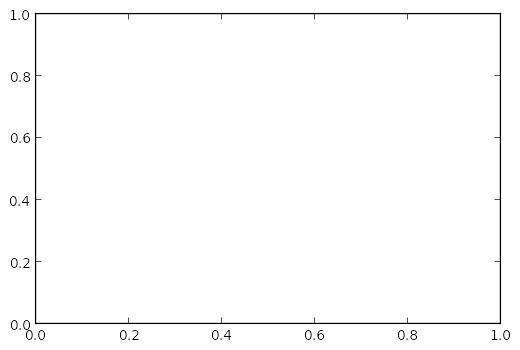

In [7]:
lat, lon = -20, 283
year, month, day = 2014, 1, 1
hour = 12.0
profile = iri_fetch(year,month,day,hour,lat,lon,var_nums=[6,17])

fig, ax = plt.subplots()
ax.plot(profile[:,1],profile[:,0])
ax.set_xlabel('electron content'); ax.set_ylabel('height (km)');
ax.set_title('IRI generated electron content\nlat: {0}; lon: {1}\n'
          'for {2}-{3:0>2}-{4:0>2} at {5} local'.format(lat,lon,year,month,day,hour))
mpld3.display(fig)

Awesome! The next step is to get vertical profiles for a set of different latitudes so we can construct a 2D region of electron content.

IndexError: invalid index

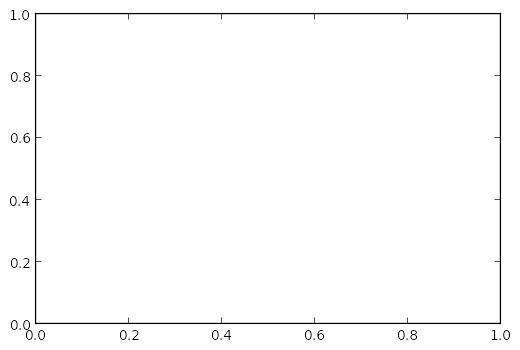

In [8]:
lats = np.linspace(-40.,40.,12)
data = []

lon = 283
year, month, day = 2014, 1, 1
hour = 12.0
for lat in lats:
    data.append( (lat,iri_fetch(year,month,day,hour,lat,lon,var_nums=[6,17])) )
    
plt.subplot(1,1,1)

for lat, profile in data:
    plt.plot(profile[:,1],profile[:,0])

plt.xlabel('electron content'); plt.ylabel('height (km)');
plt.title('IRI generated electron content\nfor various latitudes\nlon: {0}\n'
          'for {1}-{2:0>2}-{3:0>2} at {4} local'.format(lon,year,month,day,hour))
mpld3.display(plt.gcf())

Ideally, we would view this data in image form.

In [9]:
profiles = [profile[:,1] for lat, profile in data]
profiles = np.array(profiles)
alts = data[0][1][:,0]

profiles = profiles.T
H, L = profiles.shape

plt.subplot(1,1,1)
plt.imshow(profiles, origin='lower', interpolation='nearest')
plt.xlabel('latitude (degrees)'); plt.ylabel('height (km)');
plt.xticks(np.arange(0,L,11),lats[::11]); plt.yticks(np.arange(0,H,4),alts[::4])
plt.title('IRI generated electron content\nfor various latitudes\nlon: {0}\n'
          'for {1}-{2:0>2}-{3:0>2} at {4} local'.format(lon,year,month,day,hour))

mpld3.display(plt.gcf())

IndexError: invalid index

Next, we would like to add a feature to the ionosphere image, like a trough depletion. We will attempt additive and multiplicative application of Gaussian function feature to the image.

In [10]:
l, h = -20., 300.
xm, ym, sigma = (l-lats[0])/(lats[-1]-lats[0])*L, (h-alts[0])/(alts[-1]-alts[0])*H, 5
i, j = np.arange(L), np.arange(H)
ii, jj = np.meshgrid(i,j)
feat = np.exp(-((ii-xm)**2 + (jj-ym)**2) / sigma)

# create a cubic spline interpolation function to get profile value at arbitrary location
f = sp.interpolate.interp2d(i, j, profiles, kind='cubic')
# use interp function to obtain electron content in original profiles at center point of gaussian feature, i.e. (xm,ym)
orig_val = f(xm,ym)

feat = feat * orig_val * 0.5
                       
plt.subplot(1,3,1)
plt.imshow(profiles, origin='lower', interpolation='nearest')
plt.xlabel('latitude (degrees)'); plt.ylabel('height (km)');
plt.xticks(np.arange(0,L,11),lats[::11]); plt.yticks(np.arange(0,H,4),alts[::4])
plt.title('original IRI generated\nelectron content')

plt.subplot(1,3,2)
plt.imshow(feat, origin='lower', interpolation='nearest')
plt.xlabel('latitude (degrees)'); plt.ylabel('height (km)');
plt.xticks(np.arange(0,L,11),lats[::11]); plt.yticks(np.arange(0,H,4),alts[::4])
plt.title('electron content\ndepletion feature')

plt.subplot(1,3,3)
plt.imshow(profiles - feat, origin='lower', interpolation='nearest')
plt.xlabel('latitude (degrees)'); plt.ylabel('height (km)');
plt.xticks(np.arange(0,L,11),lats[::11]); plt.yticks(np.arange(0,H,4),alts[::4])
plt.title('modified IRI generated\nelectron content')


mpld3.display(plt.gcf())

NameError: name 'L' is not defined

Okay, so we have developed a procedure for generating interesting ionosphere images. Now we should compile these in way that will make them easy to use in the future.

In [11]:
class IRIFetcher:
    
    default_params = {
                'model' : 'iri_2012',  'year' : 2000,         'month' : 1,
                'day' : 1,             'time_flag' : 0,       'hour' : 1,
                'geo_flag' : 0,        'latitude' : 0,        'longitude' : 0,
                'height' : 100,        'profile' : 1,         'start' : 60,
                'stop' : 1500,         'step' : 40,           'format' : 0,
                'sun_n' : '',          'ion_n' : '',          'radio_f' : '',
                'radio_f81' : '',      'htec_max' : '',       'ne_top' : 0,
                'imap' : 0,            'ffof2' : 0,           'ib0' : 0,
                'probab' : 0,          'ffoE' : 0,            'dreg' : 0,
                'tset' : 0,            'icomp' : 0,           'nmf2' : 0,
                'hmf2' : 0,            'user_nme' : 0,        'user_hme' : 0,
                'format' : 0,          'linestyle' : 'solid', 'charsize' : '',
                'symbol' : 2,          'symsize' : '',        'yscale' : 'Linear',
                'xscale' : 'Linear',   'imagex' : 640,        'imagey' : 480,
            }
    
    default_outputs = set([6, 17])
    
    default_url = 'http://omniweb.gsfc.nasa.gov/cgi/vitmo/vitmo_model.cgi'
    
    def __init__(self, params={}, outputs=[], url=None):
        self.params = IRIFetcher.default_params
        self.params.update(params)
        self.outputs = IRIFetcher.default_outputs
        self.outputs.update(outputs)
        self.url = IRIFetcher.default_url if url is None else url
        
    def fetch(self):
        pairs = []
        for key, val in self.params.items():
            pairs.append((key, val))
        for val in self.outputs:
            pairs.append(('vars', val))
        resp = requests.post(self.url, pairs)
        parsed = BeautifulSoup(resp.text)
        pre = parsed.find('pre').text
        lines = pre.split('\n')
        data = []
        for line in lines[6:]:
            data.append([float(f) for f in line.split()])
        return data

    def create_tec_image(self, lats=[], lons=[]):
        
        if not np.any(lats):
            lats = [self.params['latitude']]
        if not np.any(lons):
            lons = [self.params['longitude']]
        assert(-90 <= np.min(lats) <= np.max(lats) <= 90)
        assert(0 <= np.min(lons) <= np.max(lons) <= 360)
        
        data0, data1 = [], []
        for lat in lats:
            for lon in lons:
                self.params['latitude'], self.params['longitude'] = lat, lon
                data1.append( self.fetch() )
            data0.append(data1)
            data1 = []
        return np.array(data0)

In [ ]:
fetcher = IRIFetcher( \
                     params={'year':2014,'month':1,'day':1,'hour':12.0,'start':60,'stop':1500,'step':40},
                     outputs=[6, 17]
                    )
lats, lons = np.linspace(-40,40,12), np.linspace(270,310,4)
data = fetcher.create_tec_image(lats, lons)

In [ ]:
%config InlineBackend.figure_format = 'png'
n_lat, n_lon, n_alt, _ = data.shape
alts = data[0,0,:,1]
profiles = data[:,:,:,0]
profiles = np.squeeze(profiles.T)

for i, lon in enumerate(lons):
    plt.subplot(1,n_lon,i)
    plt.imshow(profiles[:,i,:], origin='lower', interpolation='nearest')
    plt.xlabel('latitude (degrees)'); plt.ylabel('height (km)');
    plt.xticks(np.arange(0,n_lat,11),lats[::11]); plt.yticks(np.arange(0,n_alt,4),alts[::4])
    plt.title('IRI generated\n'
              'electron content\n'
              'for {0:3.1}$^\circ$ longitude'.format(lon))
plt.tight_layout()

plt.show()

This is the level of functionality we want.

One last function that will be helpful is a `gaussian_blob` function. As you might guess, this function generates a gaussian function for a grid mesh defined by our latitude, longitude, and altitude partition. This will be useful for creating ionosphere features on which we can test our reconstruction algorithms.

In [ ]:
def gaussian_blob(lat, lon, alt, sig_lat, sig_lon, sig_alt, lats, lons, alts):
    n_lats, n_lons, n_alts = len(lats), len(lons), len(alts)
    lat2vox, lon2vox, alt2vox = n_lats/(lats[-1]-lats[0]), \
                                n_lons/(lons[-1]-lons[0]), \
                                n_alts/(alts[-1]-alts[0])
    lat_m, lon_m, alt_m = (lat-lats[0])*lat2vox, \
                          (lon-lons[0])*lon2vox, \
                          (alt-alts[0])*alt2vox
    sig_i, sig_j, sig_k = sig_lat*lat2vox, \
                          sig_lon*lon2vox, \
                          sig_alt*alt2vox
    i, j, k = np.arange(n_lats), np.arange(n_lons), np.arange(n_alts)
    ii, jj, kk = np.meshgrid(i,j,k)
    return np.exp(-((ii-lat_m)**2/sig_i+(jj-lon_m)**2/sig_j+(kk-alt_m)**2/sig_k)).T

In [ ]:
feat = gaussian_blob(-20, 290, 300, 20, 10, 250, lats, lons, alts)

ref = np.zeros(feat.shape)
ref[0,0,:] = 1.
feat = feat+ref

for i, lon in enumerate(lons):
    plt.subplot(1,n_lon,i)
    plt.imshow(feat[:,:,i], origin='lower', interpolation='nearest')
    plt.xlabel('latitude (degrees)'); plt.ylabel('height (km)');
    plt.xticks(np.arange(0,n_lat,11),lats[::11]); plt.yticks(np.arange(0,n_alt,4),alts[::4])
    plt.title('electron content feat.\n'
              'for {0:3.1}$^\circ$ longitude'.format(lon))

plt.show()

All this functionality we have created seems really useful! For that reason, we package these functions in a module aptly named `iono_model_utils`. You can import this module using the following code:

In [12]:
import imp
iono_model_utils = imp.load_source('iono_model_utils', '../src/iono_model_utils.py')

ImportError: No module named BeautifulSoup

Now we can fetch ionosphere images to use for testing our reconstruction and, later on, even use as image bases for more sophisticated reconstruction techniques (more on this later!).